In [1]:
import kagglehub

# Download spotify-tracks-dataset
spotify_path = kagglehub.dataset_download("maharshipandya/-spotify-tracks-dataset")

print("Path to dataset files:", spotify_path)

Using Colab cache for faster access to the '-spotify-tracks-dataset' dataset.
Path to dataset files: /kaggle/input/-spotify-tracks-dataset


In [2]:
# Download customer-personality-analysis dataset
customer_path = kagglehub.dataset_download("imakash3011/customer-personality-analysis")

print("Path to dataset files:", customer_path)

100%|██████████| 62.0k/62.0k [00:00<00:00, 18.6MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/imakash3011/customer-personality-analysis/versions/1


In [3]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import seaborn as sns

In [4]:
# columns in customer-personality-analysis dataset
# People
# ID: Customer's unique identifier
# Year_Birth: Customer's birth year
# Education: Customer's education level
# Marital_Status: Customer's marital status
# Income: Customer's yearly household income
# Kidhome: Number of children in customer's household
# Teenhome: Number of teenagers in customer's household
# Dt_Customer: Date of customer's enrollment with the company
# Recency: Number of days since customer's last purchase
# Complain: 1 if the customer complained in the last 2 years, 0 otherwise

# Products
# MntWines: Amount spent on wine in last 2 years
# MntFruits: Amount spent on fruits in last 2 years
# MntMeatProducts: Amount spent on meat in last 2 years
# MntFishProducts: Amount spent on fish in last 2 years
# MntSweetProducts: Amount spent on sweets in last 2 years
# MntGoldProds: Amount spent on gold in last 2 years

# Promotion
# NumDealsPurchases: Number of purchases made with a discount
# AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
# AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
# AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
# AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
# AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
# Response: 1 if customer accepted the offer in the last campaign, 0 otherwise

# Place
# NumWebPurchases: Number of purchases made through the company’s website
# NumCatalogPurchases: Number of purchases made using a catalogue
# NumStorePurchases: Number of purchases made directly in stores
# NumWebVisitsMonth: Number of visits to company’s website in the last month

customer_data_file = customer_path + "/marketing_campaign.csv"
customer_df = pd.read_csv(customer_data_file, sep="\t")
print("Shape:", customer_df.shape)
customer_df.head(10)

Shape: (2240, 29)


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0
5,7446,1967,Master,Together,62513.0,0,1,09-09-2013,16,520,...,6,0,0,0,0,0,0,3,11,0
6,965,1971,Graduation,Divorced,55635.0,0,1,13-11-2012,34,235,...,6,0,0,0,0,0,0,3,11,0
7,6177,1985,PhD,Married,33454.0,1,0,08-05-2013,32,76,...,8,0,0,0,0,0,0,3,11,0
8,4855,1974,PhD,Together,30351.0,1,0,06-06-2013,19,14,...,9,0,0,0,0,0,0,3,11,1
9,5899,1950,PhD,Together,5648.0,1,1,13-03-2014,68,28,...,20,1,0,0,0,0,0,3,11,0


In [5]:

# drop missing value
customer_df = customer_df.dropna()
# process date and time
customer_df['Dt_Customer'] = pd.to_datetime(customer_df['Dt_Customer'], dayfirst=True)
customer_df['Age'] = 2025 - customer_df['Year_Birth']
customer_df['Customer_days'] = (pd.to_datetime('2025-11-15') - customer_df['Dt_Customer']).dt.days
# encode categorical vars
education_order = ['Basic', 'Graduation', 'Master', '2n Cycle', 'PhD']
value_to_code = {value: i for i, value in enumerate(education_order)}
customer_df['education_encoded'] = customer_df['Education'].map(value_to_code)
mapping = lambda x: 0 if x in ['Together', 'Married'] else 1
customer_df['alone_encoded'] = customer_df['Marital_Status'].apply(mapping)
# sum
customer_df['num_child'] = customer_df['Kidhome'] + customer_df['Teenhome']
customer_df['spend'] = customer_df['MntFishProducts'] + customer_df['MntFruits'] + customer_df['MntGoldProds'] + customer_df['MntWines'] + customer_df['MntMeatProducts'] + customer_df['MntSweetProducts']
customer_df['num_cmp_accepted'] = customer_df['AcceptedCmp1'] + customer_df['AcceptedCmp2'] + customer_df['AcceptedCmp3'] + customer_df['AcceptedCmp4'] + customer_df['AcceptedCmp5'] + customer_df['Response']
# drop columns
customer_df_encoded = customer_df.drop(columns=['Dt_Customer', 'Year_Birth', 'Z_CostContact', 'Z_Revenue', 'ID', 'Marital_Status', 'Education', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response', 'NumWebVisitsMonth', 'Kidhome', 'Teenhome', 'MntFishProducts', 'MntFruits', 'MntGoldProds', 'MntWines', 'MntMeatProducts', 'MntSweetProducts'])

In [6]:
display(customer_df_encoded.describe().T)

,count,mean,std,min,25%,50%,75%,max
Income,2216.0,52247.251354,25173.076661,1730.0,35303.0,51381.5,68522.0,666666.0
Recency,2216.0,49.012635,28.948352,0.0,24.0,49.0,74.0,99.0
NumDealsPurchases,2216.0,2.323556,1.923716,0.0,1.0,2.0,3.0,15.0
NumWebPurchases,2216.0,4.085289,2.740951,0.0,2.0,4.0,6.0,27.0
NumCatalogPurchases,2216.0,2.671029,2.926734,0.0,0.0,2.0,4.0,28.0
NumStorePurchases,2216.0,5.800993,3.250785,0.0,3.0,5.0,8.0,13.0
Complain,2216.0,0.009477,0.096907,0.0,0.0,0.0,0.0,1.0
Age,2216.0,56.179603,11.985554,29.0,48.0,55.0,66.0,132.0
Customer_days,2216.0,4510.521209,202.434667,4157.0,4337.0,4512.5,4686.0,4856.0
education_encoded,2216.0,1.972022,1.248795,0.0,1.0,1.0,3.0,4.0


In [7]:
customer_df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 0 to 2239
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Income               2216 non-null   float64
 1   Recency              2216 non-null   int64  
 2   NumDealsPurchases    2216 non-null   int64  
 3   NumWebPurchases      2216 non-null   int64  
 4   NumCatalogPurchases  2216 non-null   int64  
 5   NumStorePurchases    2216 non-null   int64  
 6   Complain             2216 non-null   int64  
 7   Age                  2216 non-null   int64  
 8   Customer_days        2216 non-null   int64  
 9   education_encoded    2216 non-null   int64  
 10  alone_encoded        2216 non-null   int64  
 11  num_child            2216 non-null   int64  
 12  spend                2216 non-null   int64  
 13  num_cmp_accepted     2216 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 259.7 KB


In [8]:
# normalize the data
mean = customer_df_encoded.mean()
std = customer_df_encoded.std()
customer_df_encoded_centered = (customer_df_encoded - mean) / std

In [9]:
# keep at least 80% percent of variance
pca = PCA(n_components=8, random_state=42)
X_pca = pca.fit_transform(customer_df_encoded_centered)
print("Explained variance by 8 PCs:", pca.explained_variance_ratio_.sum())


Explained variance by 8 PCs: 0.8075298227201941


## K-Means


Tuning K for Customer Dataset (Elkan's Algorithm)...


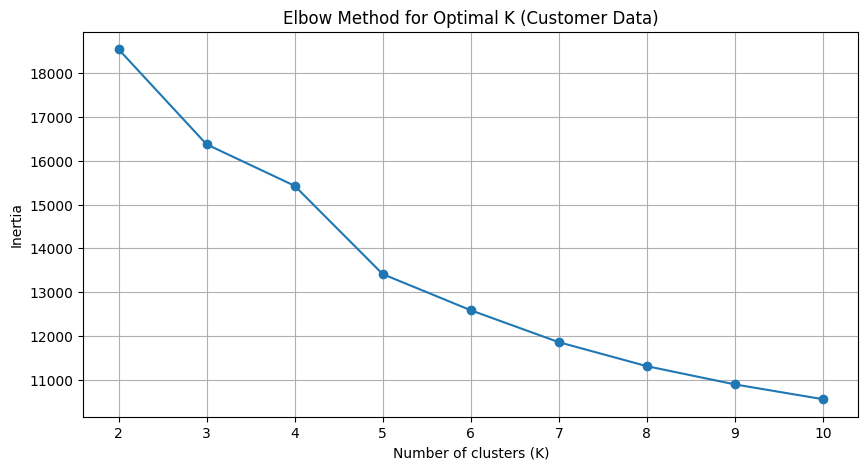

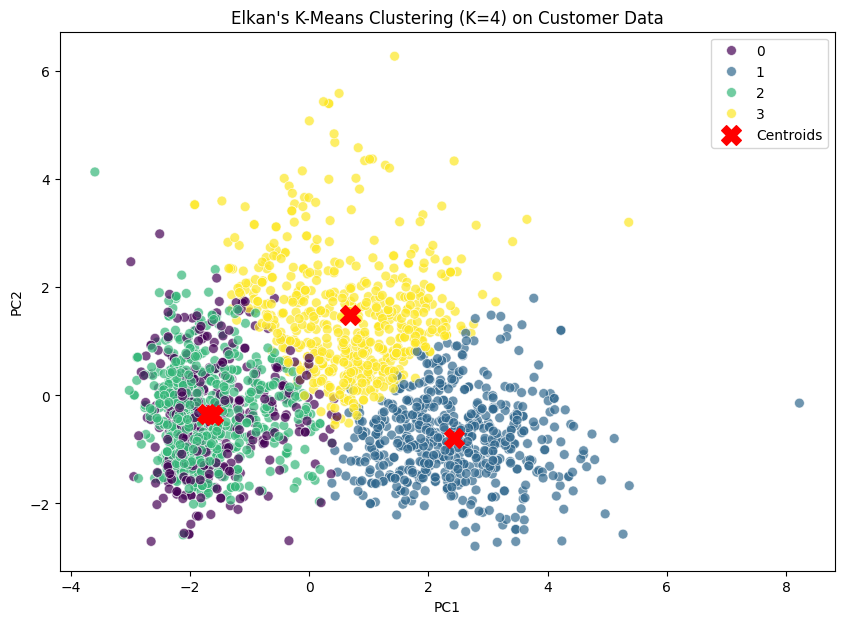


--- Validation Metrics for Customer Data (K=4) ---
Silhouette Score: 0.1673 (Higher is better)
Calinski-Harabasz Index: 459.5481 (Higher is better)
Davies-Bouldin Index: 1.9893 (Lower is better)


In [10]:
# Yaohui Wang
# DATASET 1: CUSTOMER PERSONALITY ANALYSIS

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import numpy as np

# 1. Hyperparameter Tuning (Finding Optimal K) using Elbow Method
inertia = []
k_range = range(2, 11)

print("Tuning K for Customer Dataset (Elkan's Algorithm)...")

for k in k_range:
    # algorithm='elkan' is explicitly specified here
    kmeans = KMeans(n_clusters=k, algorithm='elkan', random_state=42, n_init=10)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(10, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K (Customer Data)')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

# 2. Implementation with Optimal K
k_optimal_cust = 4
elkan_kmeans_cust = KMeans(n_clusters=k_optimal_cust, algorithm='elkan', random_state=42, n_init=10)
cust_labels = elkan_kmeans_cust.fit_predict(X_pca)

# 3. Visualization
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cust_labels, palette='viridis', s=50, alpha=0.7)
plt.scatter(elkan_kmeans_cust.cluster_centers_[:, 0], elkan_kmeans_cust.cluster_centers_[:, 1],
            s=200, c='red', label='Centroids', marker='X')
plt.title(f"Elkan's K-Means Clustering (K={k_optimal_cust}) on Customer Data")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

# 4. Cluster Validation Metrics
print(f"\n--- Validation Metrics for Customer Data (K={k_optimal_cust}) ---")
print(f"Silhouette Score: {silhouette_score(X_pca, cust_labels):.4f} (Higher is better)")
print(f"Calinski-Harabasz Index: {calinski_harabasz_score(X_pca, cust_labels):.4f} (Higher is better)")
print(f"Davies-Bouldin Index: {davies_bouldin_score(X_pca, cust_labels):.4f} (Lower is better)")


Processing Spotify Dataset...
Spotify PCA Explained Variance Ratio: [0.21873184 0.11915827]


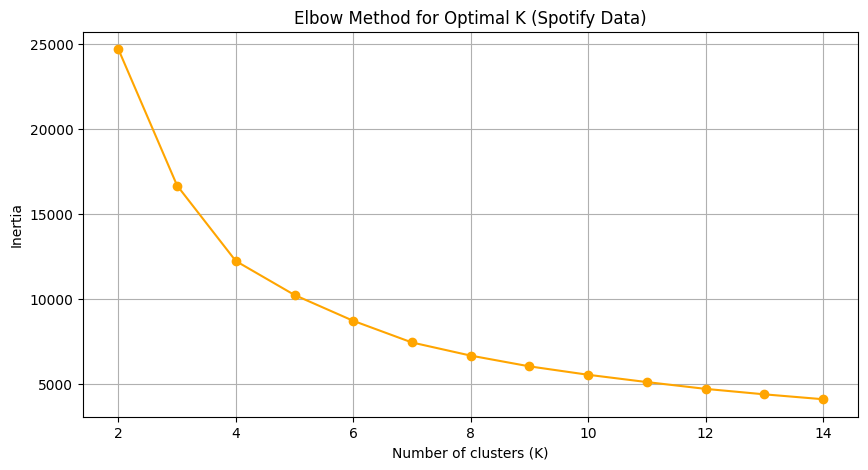

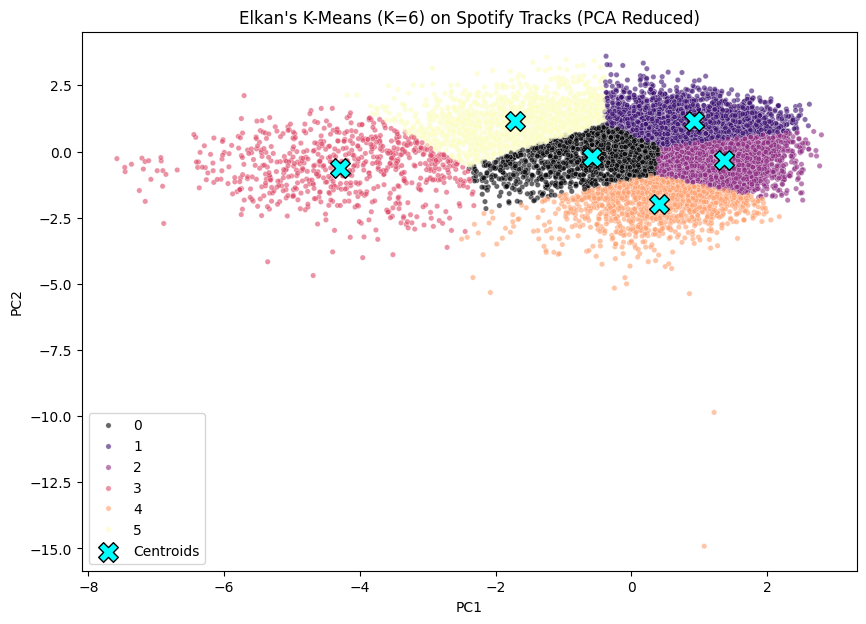


--- Validation Metrics for Spotify Data (K=6) ---
Silhouette Score: 0.3456
Calinski-Harabasz Index: 8059.6121
Davies-Bouldin Index: 0.8829


In [11]:
# Yaohui Wang
# DATASET 2: SPOTIFY TRACKS DATASET

import os
from sklearn.preprocessing import StandardScaler, LabelEncoder

# 1. Load and Preprocess Spotify Data
print("\nProcessing Spotify Dataset...")

# Locate CSV file in the downloaded path
spotify_csv_path = ""
for root, dirs, files in os.walk(spotify_path):
    for file in files:
        if file.endswith(".csv"):
            spotify_csv_path = os.path.join(root, file)
            break

spotify_df = pd.read_csv(spotify_csv_path)

# Drop non-numeric identifiers or text that won't help clustering (keeping 'track_genre' for checking later)
# We will sample the data if it is too large to render plots quickly (optional, remove sample if full power needed)
if len(spotify_df) > 10000:
    spotify_df = spotify_df.sample(10000, random_state=42)

# Select numerical features relevant for clustering audio
features = ['popularity', 'duration_ms', 'danceability', 'energy', 'key',
            'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
            'liveness', 'valence', 'tempo']

X_spot = spotify_df[features].dropna()

# Normalize the data
scaler = StandardScaler()
X_spot_scaled = scaler.fit_transform(X_spot)

# 2. Dimensionality Reduction (PCA) - Requirement (i)
# We apply PCA to reduce dimensions for visualization and efficiency
pca_spot = PCA(n_components=2) # Reducing to 2 for easy viz
X_spot_pca = pca_spot.fit_transform(X_spot_scaled)
print(f"Spotify PCA Explained Variance Ratio: {pca_spot.explained_variance_ratio_}")

# 3. Hyperparameter Tuning for Spotify
inertia_spot = []
k_range_spot = range(2, 15)

for k in k_range_spot:
    kmeans = KMeans(n_clusters=k, algorithm='elkan', random_state=42, n_init=10)
    kmeans.fit(X_spot_pca)
    inertia_spot.append(kmeans.inertia_)

# Plot Elbow
plt.figure(figsize=(10, 5))
plt.plot(k_range_spot, inertia_spot, marker='o', color='orange')
plt.title('Elbow Method for Optimal K (Spotify Data)')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

# 4. Implementation (Elkan's)
# Music genres usually require higher K, selecting K=5 based on heuristic/elbow curve
k_optimal_spot = 6
elkan_kmeans_spot = KMeans(n_clusters=k_optimal_spot, algorithm='elkan', random_state=42, n_init=10)
spot_labels = elkan_kmeans_spot.fit_predict(X_spot_pca)

# 5. Visualization
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_spot_pca[:, 0], y=X_spot_pca[:, 1], hue=spot_labels, palette='magma', s=15, alpha=0.6)
plt.scatter(elkan_kmeans_spot.cluster_centers_[:, 0], elkan_kmeans_spot.cluster_centers_[:, 1],
            s=200, c='cyan', label='Centroids', marker='X', edgecolors='black')
plt.title(f"Elkan's K-Means (K={k_optimal_spot}) on Spotify Tracks (PCA Reduced)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

# 6. Cluster Validation
print(f"\n--- Validation Metrics for Spotify Data (K={k_optimal_spot}) ---")
print(f"Silhouette Score: {silhouette_score(X_spot_pca, spot_labels):.4f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_score(X_spot_pca, spot_labels):.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin_score(X_spot_pca, spot_labels):.4f}")